# Kraskov Mutual Information
(based on k-nearest neighbours statistics)

Implementation by Gael Varoquaux:
https://gist.github.com/GaelVaroquaux/ead9898bd3c973c40429

**What to know:** 
- KMI is an approximation of MI - the values sometimes can be negative

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import numpy as np
from scipy.special import gamma,psi
from sklearn.neighbors import NearestNeighbors

from sklearn.covariance import GraphLassoCV
from sklearn.metrics import mutual_info_score
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [12]:
def nearest_distances(X, k=1):
    '''
    X = array(N,M)
    N = number of points
    M = number of dimensions

    returns the distance to the kth nearest neighbor for every point in X
    '''
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    d, _ = knn.kneighbors(X) # the first nearest neighbor is itself
    return d[:, -1] # returns the distance to the kth nearest neighbor

In [13]:
def entropy(X, k=1):
    ''' Returns the entropy of the X.

    Parameters
    ===========

    X : array-like, shape (n_samples, n_features)
        The data the entropy of which is computed

    k : int, optional
        number of nearest neighbors for density estimation

    Notes
    ======

    Kozachenko, L. F. & Leonenko, N. N. 1987 Sample estimate of entropy
    of a random vector. Probl. Inf. Transm. 23, 95-101.
    See also: Evans, D. 2008 A computationally efficient estimator for
    mutual information, Proc. R. Soc. A 464 (2093), 1203-1215.
    and:
    Kraskov A, Stogbauer H, Grassberger P. (2004). Estimating mutual
    information. Phys Rev E 69(6 Pt 2):066138.
    '''

    # Distance to kth nearest neighbor
    r = nearest_distances(X, k) # squared distances
    n, d = X.shape
    volume_unit_ball = (np.pi**(.5*d)) / gamma(.5*d + 1)
    '''
    F. Perez-Cruz, (2008). Estimation of Information Theoretic Measures
    for Continuous Random Variables. Advances in Neural Information
    Processing Systems 21 (NIPS). Vancouver (Canada), December.

    return d*mean(log(r))+log(volume_unit_ball)+log(n-1)-log(k)
    '''
    return (d*np.mean(np.log(r + np.finfo(X.dtype).eps))
            + np.log(volume_unit_ball) + psi(n) - psi(k))

In [14]:
# x = np.random.randn(2000)
# y = np.random.randn(2000)

# X = np.stack((x,y), axis=1)

In [15]:
# for i in range(1,15):
#     print('k = {:03} | entropy = {}'.format(i, entropy(X, k=i)))

In [16]:
def mutual_information(variables, k=1):
    '''
    Returns the mutual information between any number of variables.
    Each variable is a matrix X = array(n_samples, n_features)
    where
      n = number of samples
      dx,dy = number of dimensions
    Optionally, the following keyword argument can be specified:
      k = number of nearest neighbors for density estimation
    Example: mutual_information((X, Y)), mutual_information((X, Y, Z), k=5)
    '''
    if len(variables) < 2:
        raise AttributeError(
                "Mutual information must involve at least 2 variables")
    all_vars = np.hstack(variables)
    
    MI = sum([entropy(X, k=k) for X in variables]) - entropy(all_vars, k=k)
    
    return MI

In [18]:
# for i in range(1,20):
#     print('k = {:03} | MI = {}'.format(i, mutual_information((X,Y), k=i)))

In [19]:
# load the data

df1    = pd.read_csv(r"C:\Users\Mala\FunctionalConnectivity_AoNBrainhackWarsaw\datasets\fMRI\HCP_parcellated_smoothing5_100subjects_Glasser_restingstate_day1\101107.csv")
data1  = df1.values
Nvars  = data1.shape[1]

labels_Glasser  = pd.read_csv(r"C:\Users\Mala\FunctionalConnectivity_AoNBrainhackWarsaw\datasets\fMRI\labels_Glasser.csv",header=None)[0].tolist()

In [20]:
# compute FUNCTIONAL CONNECTIVITY on the data with KRASKOV MUTUAL INFORMATION:        
# you need to specify the number of neighbours

def KMI(data, k):
    matMI = np.zeros((Nvars,Nvars))

    for ix in np.arange(Nvars):
        for jx in np.arange(ix+1,Nvars):
            matMI[ix,jx] = mutual_information((data[:,ix].reshape(-1, 1), data[:,jx].reshape(-1, 1)), k)
            matMI[jx,ix] = matMI[ix,jx]
    return matMI

In [21]:
kmi16 = KMI(data1, 16)

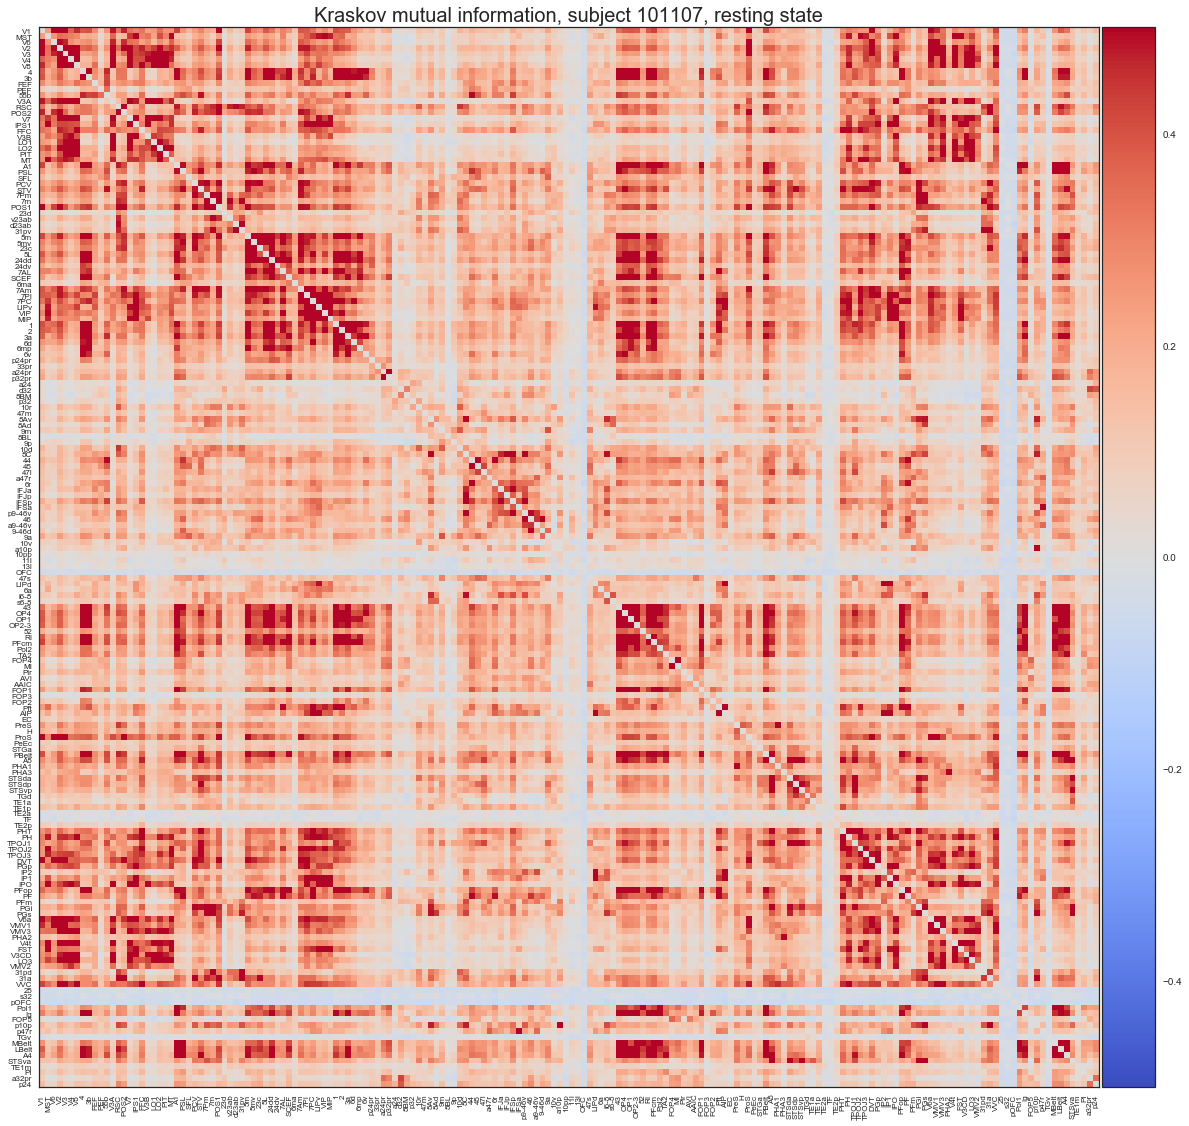

In [26]:
# plot KMI results

f = plt.figure(figsize=(20,20))
ax = plt.gca()
im = plt.imshow(kmi16, clim=[-0.5,0.5],cmap='coolwarm')
plt.xticks(np.arange(len(labels_Glasser)), labels_Glasser, rotation='vertical', fontsize=8)
plt.yticks(np.arange(len(labels_Glasser)), labels_Glasser, fontsize=8)
plt.title('Kraskov mutual information, subject 101107, resting state', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()